This short notebook simply converts the attention output of the Longformer model into a traditional seq_len x seq_len format and plots the attention using matplotlib.

### Import and Install Dependencies

In [1]:
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format("cogs402longformer/"))

In [2]:
pip install datasets --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install transformers

In [4]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


###Import Dataset and Model

Remember to adjust the path for the models and dataset and change the max_length accordingly.

In [5]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [6]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
max_length = 2048
def longformer_finetuned_papers():
    model = AutoModelForSequenceClassification.from_pretrained('danielhou13/longformer-finetuned_papers_v2', num_labels = 2, output_attentions = True)
    return model

def preprocess_function(tokenizer, example, max_length):
    example.update(tokenizer(example['text'], padding='max_length', max_length=max_length, truncation=True))
    return example

def get_papers_dataset(dataset_type):
    # max_length = 2048
    dataset = load_dataset("danielhou13/cogs402dataset")[dataset_type]

    # tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    dataset = dataset.map(lambda x: preprocess_function(tokenizer, x, max_length), batched=True)
    setattr(dataset, 'input_columns', ['input_ids', 'attention_mask'])
    setattr(dataset, 'target_columns', ['labels'])
    setattr(dataset, 'max_length', max_length)
    setattr(dataset, 'tokenizer', tokenizer)
    return dataset

def papers_validation_set():
    return get_papers_dataset('validation')

In [7]:
# def preprocess_function(tokenizer, example, max_length):
#     example.update(tokenizer(example['text'], padding='max_length', max_length=max_length, truncation=True))
#     return example

# def longformer_finetuned_news():
#     model = AutoModelForSequenceClassification.from_pretrained('danielhou13/longformer-finetuned-news-cogs402', num_labels = 2)
#     return model

# def get_news_dataset(dataset_type):
#     max_length = 2048
#     dataset = load_dataset("danielhou13/cogs402dataset2")[dataset_type]

#     tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
#     dataset = dataset.map(lambda x: preprocess_function(tokenizer, x, max_length), batched=True)

#     labels = map(int, dataset['hyperpartisan'])
#     print(type(dataset['hyperpartisan']))
#     labels = list(labels)
#     dataset = dataset.add_column("labels", labels)

#     dataset = dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
#     print(dataset)
#     setattr(dataset, 'input_columns', ['input_ids', 'attention_mask'])
#     setattr(dataset, 'target_columns', ['labels'])
#     setattr(dataset, 'max_length', max_length)
#     setattr(dataset, 'tokenizer', tokenizer)
#     return dataset

# def news_train_set():
#     return get_news_dataset('train')

# def news_test_set():
#     return get_news_dataset('validation')

In [8]:
cogs402_test = papers_validation_set()
model = longformer_finetuned_papers()
columns = cogs402_test.input_columns + cogs402_test.target_columns
print(columns)
cogs402_test.set_format(type='torch', columns=columns)
cogs402_test=cogs402_test.remove_columns(['text'])

Using custom data configuration danielhou13--cogs402dataset-cf543ab32213b84f
Reusing dataset parquet (C:\Users\danie\.cache\huggingface\datasets\parquet\danielhou13--cogs402dataset-cf543ab32213b84f\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\danie\.cache\huggingface\datasets\parquet\danielhou13--cogs402dataset-cf543ab32213b84f\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901\cache-b55a542d2990705a.arrow


['input_ids', 'attention_mask', 'labels']


In [9]:
if torch.cuda.is_available():
    model = model.cuda()

print(model.device)

cuda:0


### Evaluate example 

Replace number in testval with whatever example you wish to evaluate.

In [10]:
test_val = [976]
testexam = cogs402_test[test_val]

In [11]:
# print(test['labels'][923])

We do the forward pass of our model and grab the attentions, stacking them to create a tensor of shape: (layer, batch, head, seq_len, x + sliding_window_attention + 1). x is the number of tokens with global attention. The global attention is a tensor of shape (layer, batch, head, seq_len, x).

In [12]:
output = model(testexam["input_ids"].cuda(), attention_mask=testexam['attention_mask'].cuda(), labels=testexam['labels'].cuda(), output_attentions = True)
batch_attn = output[-2]
output_attentions = torch.stack(batch_attn).cpu()
global_attention = output[-1]
output_global_attentions = torch.stack(global_attention).cpu()
print("output_attention.shape", output_attentions.shape)
print("gl_output_attention.shape", output_global_attentions.shape)

output_attention.shape torch.Size([12, 1, 12, 2048, 514])
gl_output_attention.shape torch.Size([12, 1, 12, 2048, 1])


In [13]:
# print(os.getcwd())
# yes = torch.load("resources/longformer_test2/epoch_3/aggregate_attn.pt")

Convert sliding attention matrix to correct seq_len x seq_len matrix. The full details of these functions can be found [here](https://colab.research.google.com/drive/1Kxx26NtIlUzioRCHpsR8IbSz_DpRFxEZ#scrollTo=liVhkxiH9Le0). A brief summary of these functions are that they change the output attention tensor of shape (layer, batch, head, seq_len, x + attention_window + 1) and a global attention tensor of shape (layer, batch, head, seq_len, x) to a single ndarray of shape (layer, batch, head, seq_len, seq_len).

In [14]:
def create_head_matrix(output_attentions, global_attentions):
    new_attention_matrix = torch.zeros((output_attentions.shape[0], 
                                      output_attentions.shape[0]))
    for i in range(output_attentions.shape[0]):
        test_non_zeroes = torch.nonzero(output_attentions[i]).squeeze()
        test2 = output_attentions[i][test_non_zeroes[1:]]
        new_attention_matrix_indices = test_non_zeroes[1:]-257 + i
        new_attention_matrix[i][new_attention_matrix_indices] = test2
        new_attention_matrix[i][0] = output_attentions[i][0]
        new_attention_matrix[0] = global_attentions.squeeze()[:output_attentions.shape[0]]
    return new_attention_matrix.detach().cpu().numpy()


def attentions_all_heads(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = create_head_matrix(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return np.stack(new_matrix)


def all_batches(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = attentions_all_heads(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return np.stack(new_matrix)

def all_layers(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
        matrix = all_batches(output_attentions[i], global_attentions[i])
        new_matrix.append(matrix)
    return np.stack(new_matrix)

In [15]:
converted_mat = all_layers(output_attentions, output_global_attentions)
print(converted_mat.shape)

(12, 1, 12, 2048, 2048)


In [16]:
del(output_attentions)
del(global_attention)

The following block is the normalization code by T3-vis. It operates by converting the values into colour values which we can use for plotting. For each layer and head in the complete attention matrix, we take the (seq_len, seq_len) matrix, normalize all the values, then scale it so each value is between 0-255. Arrays of the same shape representing colour channels are then made, and the colours we do not want are masked and set to 0. Finally we stack our 4 matrices so that each item in our original array now contains 4 colour values (red, blue, green, alpha). We then convert this into a list, keeping the 4 colour values of each item sequential. 

**The input is an array of shape: (layer, batch, head, seq_len, seq_len)**. 

**The output shape is a (4 x layer x batch x head x seq_len x seq_len) list**

The aggregated attention contains layer x batch x head x seq_len x seq_len values in the attention matrix and there are 4 colour channels: red, blue, green, alpha (controls how opaque the colour is).

In [17]:
def format_attention_image(attention):
    formatted_attn = []
    for layer_idx in range(attention.shape[0]):
        print("layer", layer_idx)
        for head_idx in range(attention.shape[1]):
            formatted_entry = {
                'layer': layer_idx,
                'head': head_idx
            }

            # Flatten value of log attention normalize between 255 and 0
            if len(attention[layer_idx, head_idx]) == 0:
                continue
            attn = np.array(attention[layer_idx, head_idx]).flatten()
            attn = (attn - attn.min()) / (attn.max() - attn.min())
            alpha = np.round(attn * 255)
            red = np.ones_like(alpha) * 255
            green = np.zeros_like(alpha) * 255
            
            blue = np.zeros_like(alpha) * 255

            attn_data = np.dstack([red,green,blue,alpha]).reshape(alpha.shape[0] * 4).astype('uint8')
            formatted_entry['attn'] = attn_data.tolist()
            formatted_attn.append(formatted_entry)
    return formatted_attn

In [18]:
example_attention = format_attention_image(converted_mat.squeeze())

layer 0
layer 1
layer 2
layer 3
layer 4
layer 5
layer 6
layer 7
layer 8
layer 9
layer 10
layer 11


In [19]:
del(converted_mat)

## Downsampling
The matrix is incredibly large so it might be beneficial to downsample the matrix into a smaller one. We split the matrix into multiple sections determined by a stride number. To determine the value of the downsampled pixel, we add up all of the saturation values for each pixel in a section, and average them based on the number of total pixels in the piece. Lastly, we normalize the values of our new matrix into a range of 0-255 (as per RGBA values used by matplotlib and plotly). 

Input: matrix of shape (M,N)
Output: matrix of shape (M//A, N//B) where A,B is the stride numbers. We recommend passing in powers of 2 for the stride.

In [20]:
# get a subset of the matrix based on the new pixel size
# if the slice is at the end of the row or column, we take the remaining pixels and at it to the slice
def get_slice(matrix, row, col, row_stride, col_stride, row_end, col_end):
    if (row_end and col_end):
        return matrix[row*row_stride:, col*col_stride:]
    elif row_end:
        return matrix[row*row_stride:, col*col_stride:col*col_stride+col_stride]
    elif col_end:
        return matrix[row*row_stride:row*row_stride+row_stride, col*col_stride:]
    else:
        return matrix[row*row_stride:row*row_stride+row_stride, col*col_stride:col*col_stride+col_stride]

def find_average(matrix):
    #find how many reds and blues there are
    red_count = np.count_nonzero(matrix[:,:,-1][matrix[:,:,0] == 255])
    blue_count = np.count_nonzero(matrix[:,:,-1][matrix[:,:,2] == 255])

    # count number of zeros
    zeros_count = matrix[:,:,-1][matrix[:,:,-1] == 0].shape[0]

    #add up the totals for all the reds and blues
    red_sum = 0
    blue_sum = 0
    assert ((zeros_count + red_count + blue_count) == (matrix.shape[0] * matrix.shape[1]))
    #if the total number of reds are not 0, sum up the red total
    if (red_count != 0):
        red_sum = np.sum(matrix[:,:,3][matrix[:,:,0] == 255])
        red_avg = red_sum/(matrix.shape[0] * matrix.shape[1])

    #if the total number of blues are not 0, sum up the blue total
    if (blue_count != 0):
        blue_sum = np.sum(matrix[:,:,3][matrix[:,:,2] == 255])
        blue_avg = blue_sum/(matrix.shape[0] * matrix.shape[1])

    # if both red and blue are 0, then its an empty space
    if (red_count == 0 and blue_count == 0):
        return np.array((0,0,0,0))
        #if blue is 0 then just average up red
    elif (blue_count == 0):
        return np.array((255,0,0, red_avg))
        #if red is 0 then just average up blue
    elif (red_count == 0):
        return np.array((0,0,255, blue_avg))
        #if red average is greater than blue average then return red average (penalized by blue average)
    elif (red_avg > blue_avg):
        return np.array((0,128,0, red_avg - blue_avg))
        #if blue average is greater than red average, then return blue average (penalized by red average)
    else:
        return np.array((128,0,128, blue_avg - red_avg))

# main function
def section_conv(matrix, row_stride, col_stride):
    # pass in the (N, M, 4) matrix we are working with and the number of pixels
    # you want to reduce the rows/columns by

    # Input matrix size: (N, M, 4)
    # Output matrix size: (N//row_stride, M//col_stride, 4)

    #get number of rows and column numbers based on how many pixels per section
    row = matrix.shape[0] // row_stride
    col = matrix.shape[1] // col_stride

    #initialize a new array to return
    new_array = np.empty((row,col,4))

    for i in range(row):
        # check if its the end of a row or column for slice method
        row_end = (i == (row-1))
        for j in range(col):
            col_end = (j == (col-1))

            # get the slice we are working with
            section_curr = get_slice(matrix, i, j, row_stride, col_stride, row_end, col_end)
            #get the average and add it into the new array
            new_array[i, j] = find_average(section_curr)

    if (row == 1) and (col == 1):
        return new_array

    # normalize if needed
    new_array[:,:,3] = (new_array[:,:,3] - np.min(new_array[:,:,3])) / (np.max(new_array[:,:,3]) - np.min(new_array[:,:,3]))
    new_array[:,:,3] *= 255
    return new_array

To visualize the attention, we use matplotlib to plot out the attention matrix. First, we get an attention matrix from the above list from range [0 ... head x layer - 1] where every 12 items is a new layer. For example, item 0 is "layer 1 head 1" and item 12 is "layer 2 head 1". Note that we have to use the `attn` key to grab the matrix. Then we reshape the matrix from a 4 x seq_len x seq_len list to an array of shape (seq_len, seq_len, 4). 


Then, with matplotlib's [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function, it plots a 2-D heatmap of shape (seq_len, seq_len). The darker the part of the image looks on the heatmap, the higher the amount of attention between the tokens.

The block of code below demonstrates how to get plot one specific head from one layer.

In [21]:
# from matplotlib import pyplot as plt
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 600

# fig, ax = plt.subplots()
# fig.set_figheight(5)
# fig.set_figwidth(5)

# #replace 0 with the matrix you wish to visualize
# example = example_attention[16]
# col_num = example['head']
# row_num = example['layer']
# print("Layer (row):", row_num, "Head (col):", col_num)
# c = ax.imshow(np.array(example['attn']).reshape((2048,2048,4)), interpolation="nearest")

# # ax.set_xticks([])
# # ax.set_yticks([])

# plt.savefig('exampleattnheatmapsingle.png', pad_inches=0.0)
# plt.show()

The following is the same as the previous, but created using plotly instead of matplotlib. It allows for a more interactivity (being able to hover over the graph to identify values)

Layer (row): 0 Head (col): 2


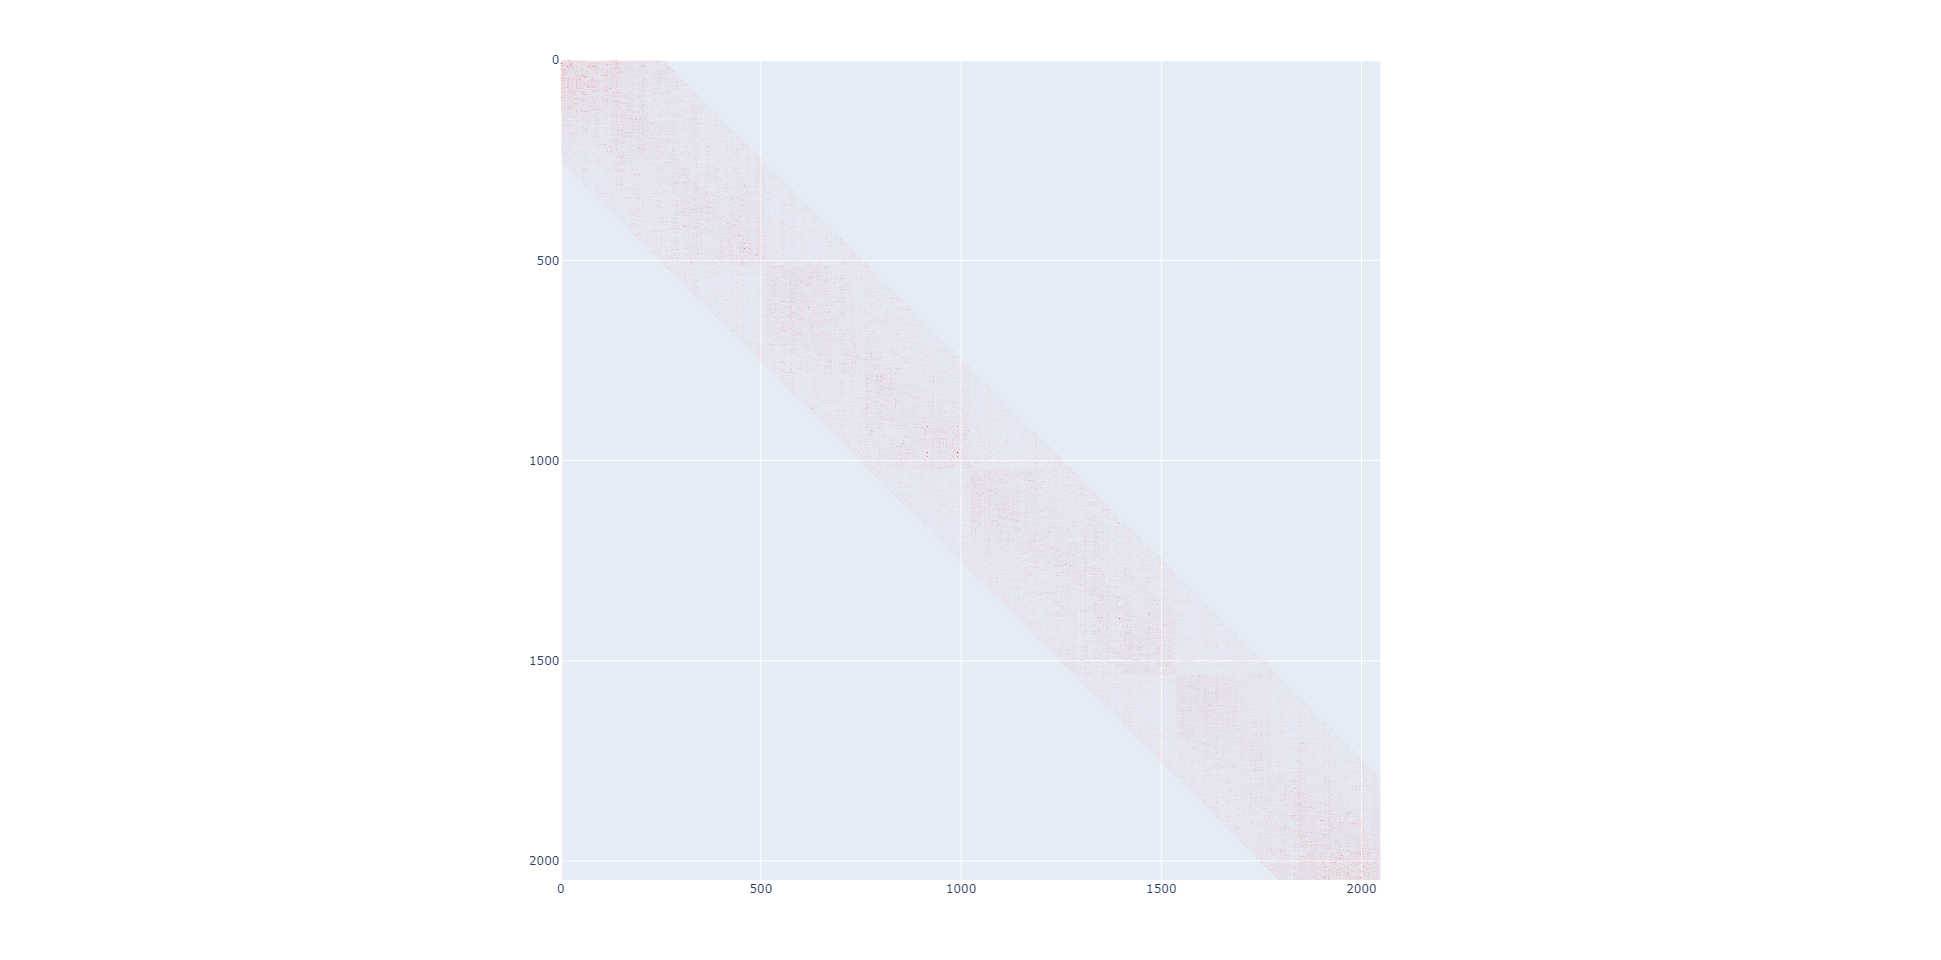

In [22]:
import math 
from tqdm import tqdm
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.express as px

pyo.init_notebook_mode()

example = example_attention[2]
col_num = example['head']
row_num = example['layer']
example_attn = np.array(example['attn'], dtype=np.uint8).reshape((max_length,max_length,4))

print("Layer (row):", row_num, "Head (col):", col_num)
c = px.imshow(example_attn, width = 1280, height = 960)

# ax.set_xticks([])
# ax.set_yticks([])

c.show()

We have functionally the same code as the previous block, but here we are plotting every attention matrix (all 144 in our code). With 12 heads and 12 layers, the key difference is we have to keep track of the current row (layers) and column (head). Thankfully, the function above lets us store the head and the layer. 

With 12 heads per layer, we create a new row every 12 plots. Then, we can plot the matrix at the correct slot using matplotlib's subplot (axs in our code).

Lastly, we delete the current item in the list after plotting to free up memory given the large array size we are working with.

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [03:21<00:00,  1.40s/it]


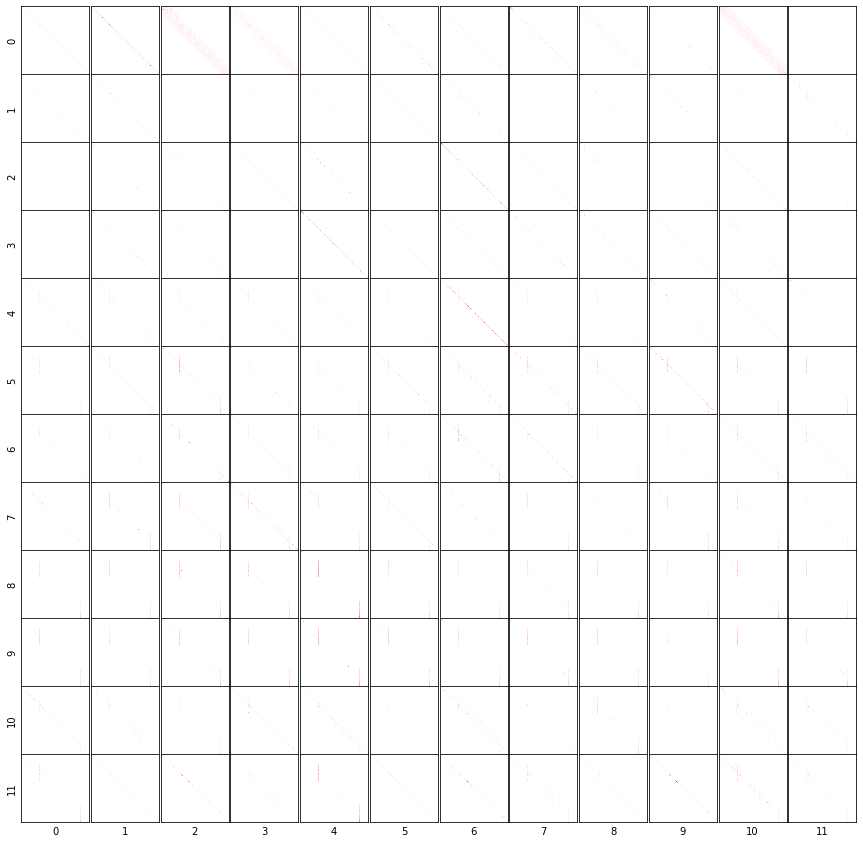

In [23]:
import math 
from tqdm import tqdm

# plt.rcParams['figure.dpi'] = 400

fig, axs = plt.subplots(12,12,figsize=(15,15))
row_num=0
for i in tqdm(range(len(example_attention))):
    test2 = np.array(example_attention[0]['attn']).reshape((2048,2048,4))
    col_num = example_attention[0]['head']
    row_num = example_attention[0]['layer']
    c= axs[row_num, col_num].imshow(test2, interpolation="nearest")
    axs[row_num, col_num].set(xlabel = str(col_num), ylabel = str(row_num))
    axs[row_num, col_num].xaxis.set_ticks([])
    axs[row_num, col_num].yaxis.set_ticks([])
#   #saving memory here
    del(example_attention[0])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('exampleattnheatmap.pdf')
plt.show()

We create the same 144 plots (heads x layers) using plotly for more interactivity (being able to hover over the graph to identify values)

In [24]:
# #num heads
# row_title = []
# for i in range(12):
#     head_val = f"head{i+1}"
#     row_title.append(head_val)

# #num layers
# column_title = []
# for i in range(12):
#     layer_val = f"layer{i+1}"
#     column_title.append(layer_val)

# fig = make_subplots(rows=12, cols=12, x_title="heads", y_title="layers", 
#                     column_titles=column_title, row_titles=row_title,
#                     vertical_spacing=0.02, horizontal_spacing = 0.02)

# for i in tqdm(range(len(example_attention))):
#     test2 = np.array(example_attention[0]['attn'], dtype=np.uint8).reshape((max_length,max_length,4))
#     col_num = example_attention[0]['head']
#     row_num = example_attention[0]['layer']
#     # test2[:,::2, [0,2]] = [0,255]
#     # b = np.ndarray.astype(section_conv(test2,16,16), "uint8")

#     fig.add_trace(px.imshow(test2).data[0],
#               row=row_num+1, col=col_num + 1)

#     #saving memory here
#     del(example_attention[0])
    
# fig.update_layout(height=1000, width=1000)
# fig.show()